In [2]:
from dnnbrain_lib import RDM, Stimulus
import numpy as np

In [3]:
brm_path = "data/restask.rdm.h5"
drm_path = "data/restask2.rdm.h5"

In [4]:
brdm = RDM()
brdm.load(brm_path)
drdm = RDM()
drdm.load(drm_path)

In [5]:
import matplotlib.pyplot as plt
import numpy as np


def imgarray_show(x, nrows=1, ncols=1, row_label=None, vmin=None, vmax=None,
                  figsize=(10, 6), cmap='coolwarm', cbar=False, frame_on=True,
                  img_names=None, show=True, save_path=None):
    """
    create a figure showing multiple images.
    
    Parameters
    ----------
    x : list 
        List of image array (2d or 3d-RGB[A]).
    nrows, ncols : int 
        Number of rows/columns of the subplot grid.
    row_label : list 
        Row names.
    vmin, vmax : scalar 
        **vmin** and **vmax** define the value range of 
        colormap applied to all images. By default, colormaps
        adapt to each image's value range.
    figsize : float, float
        *width*, height of figure in inches.
    cmap : str 
        The Colormap instance or registered colormap name used 
        to map scalar data to colors. 
    frame_on : bool 
        Set whether the axes rectangle patch is drawn.
    img_names : list 
        Image names with the same length as x.
    show : bool 
        Set whether the figure is displayed.
    save_path : str 
        File path to save the figure.
        
    Return
    ------
    matplotlib.figure : object
    """

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols,
                            subplot_kw={'xticks': [], 'yticks': [],
                                        'frame_on': frame_on},
                            figsize=figsize)

    for i, ax in enumerate(axs.flat[:len(x)]):
        if row_label is not None and np.mod(i, ncols) == 0:
            ax.set_ylabel(row_label[i//ncols])
        if img_names is not None:
            ax.set_xlabel(img_names[i])
        img = ax.imshow(x[i], cmap=cmap, vmin=vmin, vmax=vmax)
        if cbar:
            fig.colorbar(img, ax=ax)
    plt.tight_layout()
    
    if save_path is not None:
        plt.savefig(save_path)

    if show is True:
        plt.show()

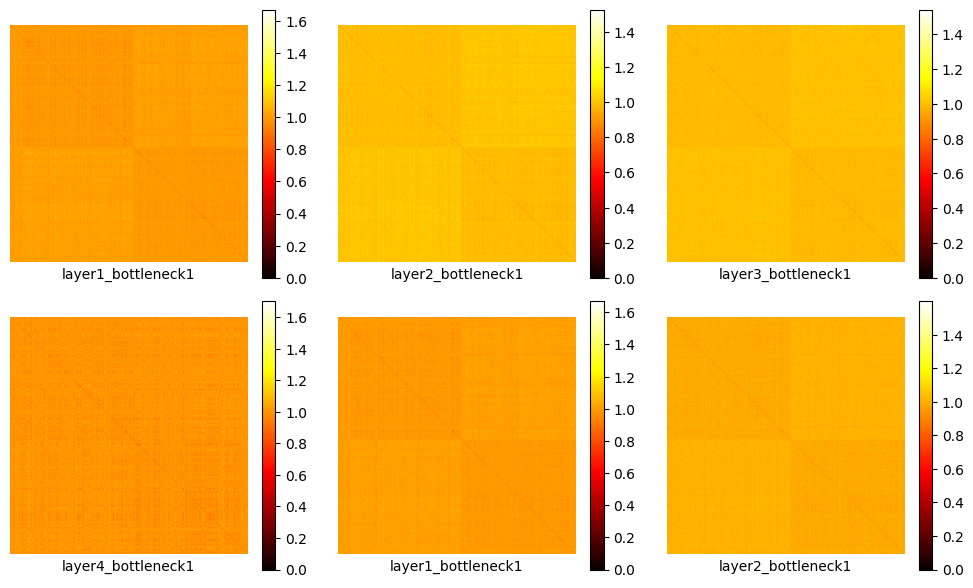

In [6]:
stim = Stimulus()
stim.load('data/all_5000scenes.stim.csv')
labels = stim.get('label')
labels_uniq = np.unique(labels)
indices = []
for lbl in labels_uniq:
    indices.extend(np.where(labels == lbl)[0])

# get brain RDM
layers = ["layer1_bottleneck1", "layer2_bottleneck1", "layer3_bottleneck1", "layer4_bottleneck1"]
#layers = "conv1_relu conv2_relu conv3_relu conv4_relu conv5_relu".split(" ")

rdm_arrs = []

img_names = layers
for layer in layers:
    drdm_arr = brdm.get(layer, False)[0]
    drdm_arr = drdm_arr + drdm_arr.T
    rdm_arrs.append(drdm_arr[indices][:, indices])

# get DNN RDMs
layers = ["layer1_bottleneck1", "layer2_bottleneck1", "layer3_bottleneck1", "layer4_bottleneck1"]
#layers = "conv1_relu conv2_relu conv3_relu conv4_relu conv5_relu".split(" ")

img_names.extend(layers)
for layer in layers:
    drdm_arr = drdm.get(layer, False)[0]
    drdm_arr = drdm_arr + drdm_arr.T
    rdm_arrs.append(drdm_arr[indices][:, indices])

# plot
imgarray_show(rdm_arrs, 2, 3, cmap='hot', cbar=True,
              frame_on=False, img_names=img_names)

In [7]:
from scipy.stats import pearsonr


for idx, layer in enumerate(layers):
    drdm_arr = drdm.get(layer, True)[0]
    for idx2, layer2 in enumerate(layers):
        drdm_arr2 = brdm.get(layer, True)[0]   
        corr = pearsonr(drdm_arr2, drdm_arr)[0]
        print(f'VTC corr {layer}, {layer2}: {corr}')

VTC corr layer1_bottleneck1, layer1_bottleneck1: 0.9322597635320446
VTC corr layer1_bottleneck1, layer2_bottleneck1: 0.9322597635320446
VTC corr layer1_bottleneck1, layer3_bottleneck1: 0.9322597635320446
VTC corr layer1_bottleneck1, layer4_bottleneck1: 0.9322597635320446
VTC corr layer2_bottleneck1, layer1_bottleneck1: 0.847638223864944
VTC corr layer2_bottleneck1, layer2_bottleneck1: 0.847638223864944
VTC corr layer2_bottleneck1, layer3_bottleneck1: 0.847638223864944
VTC corr layer2_bottleneck1, layer4_bottleneck1: 0.847638223864944
VTC corr layer3_bottleneck1, layer1_bottleneck1: 0.7790814365225892
VTC corr layer3_bottleneck1, layer2_bottleneck1: 0.7790814365225892
VTC corr layer3_bottleneck1, layer3_bottleneck1: 0.7790814365225892
VTC corr layer3_bottleneck1, layer4_bottleneck1: 0.7790814365225892
VTC corr layer4_bottleneck1, layer1_bottleneck1: 0.4164160955328732
VTC corr layer4_bottleneck1, layer2_bottleneck1: 0.4164160955328732
VTC corr layer4_bottleneck1, layer3_bottleneck1: 0.4

In [11]:
"""

Resnet18 Baseline:

VTC corr layer1_bottleneck1: 0.01427822972665456
VTC corr layer2_bottleneck1: 0.012378818431529322
VTC corr layer3_bottleneck1: 0.011979413597065688
VTC corr layer4_bottleneck1: 0.011589944948884384

AlexNet reproduced:

VTC corr conv1_relu: 0.033719160383963276
VTC corr conv2_relu: 0.09919918875631141
VTC corr conv3_relu: 0.12037730518275609
VTC corr conv4_relu: 0.1511800380089967
VTC corr conv5_relu: 0.16356918286743927

Resnet18 Task 1:
VTC corr layer1_bottleneck1: 0.026713153454809263
VTC corr layer2_bottleneck1: 0.06442884554564159
VTC corr layer3_bottleneck1: 0.06292535543716873
VTC corr layer4_bottleneck1: 0.02078512181853327

Resnet18 Task 2:

VTC corr layer1_bottleneck1: 0.026740295596239916
VTC corr layer2_bottleneck1: 0.054774536678828215
VTC corr layer3_bottleneck1: 0.06590026667212436
VTC corr layer4_bottleneck1: 0.025626797442419927

"""

'\n\nResnet18 Baseline:\n\nVTC corr layer1_bottleneck1: 0.01427822972665456\nVTC corr layer2_bottleneck1: 0.012378818431529322\nVTC corr layer3_bottleneck1: 0.011979413597065688\nVTC corr layer4_bottleneck1: 0.011589944948884384\n\nAlexNet reproduced:\n\nVTC corr conv1_relu: 0.033719160383963276\nVTC corr conv2_relu: 0.09919918875631141\nVTC corr conv3_relu: 0.12037730518275609\nVTC corr conv4_relu: 0.1511800380089967\nVTC corr conv5_relu: 0.16356918286743927\n\nResnet18 Task 1:\nVTC corr layer1_bottleneck1: 0.026713153454809263\nVTC corr layer2_bottleneck1: 0.06442884554564159\nVTC corr layer3_bottleneck1: 0.06292535543716873\nVTC corr layer4_bottleneck1: 0.02078512181853327\n\n'

In [8]:
for idx, layer in enumerate(layers):
    drdm_arr = drdm.get(layer, True)[0]
    drdm_arr2 = brdm.get(layer, True)[0]   
    corr = pearsonr(drdm_arr2, drdm_arr)[0]
    print(f'VTC corr {layer}, {layer2}: {corr}')

VTC corr layer1_bottleneck1, layer4_bottleneck1: 0.9322597635320446
VTC corr layer2_bottleneck1, layer4_bottleneck1: 0.847638223864944
VTC corr layer3_bottleneck1, layer4_bottleneck1: 0.7790814365225892
VTC corr layer4_bottleneck1, layer4_bottleneck1: 0.4164160955328732
